<a href="https://colab.research.google.com/github/kingofnonames/Machine-Learning---IT3190/blob/rf/rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import h5py
import numpy as np

data_path = "D:\Tài liệu học đại học\ProjectML\processed_data.h5"
with h5py.File(data_path, "r") as hf:
    X = hf["X"][:]
    y = hf["y"][:]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (7000, 16640)
y shape: (7000,)


In [2]:
from sklearn.preprocessing import LabelEncoder

if y.dtype.type is np.str_ or y.dtype.type is np.object_:  #
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
else:
    y_encoded = y


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print("Train:", X_train.shape)
print("Test:", X_test.shape)


Train: (5600, 16640)
Test: (1400, 16640)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

model = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4, 8],
}


random_search_rf = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=17,
    cv=5,
    scoring='accuracy',
    random_state=42
)

In [13]:
random_search_rf.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=17,
                   param_distributions={'max_depth': [10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [50, 100, 150, 200]},
                   random_state=42, scoring='accuracy')

In [14]:
print(random_search_rf.best_params_)

{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20}


In [15]:
rf_model = random_search_rf.best_estimator_

Test accuracy: 0.8821428571428571
Classification Report:
              precision    recall  f1-score   support

           0     0.8238    0.8650    0.8439       200
           1     0.8324    0.7450    0.7863       200
           2     0.8932    0.9200    0.9064       200
           3     0.8154    0.7950    0.8051       200
           4     0.9091    0.9500    0.9291       200
           5     0.9596    0.9500    0.9548       200
           6     0.9360    0.9500    0.9429       200

    accuracy                         0.8821      1400
   macro avg     0.8813    0.8821    0.8812      1400
weighted avg     0.8813    0.8821    0.8812      1400

Số lượng mẫu bị gán nhãn sai trên tập test: 165
Tỷ lệ mẫu sai: 11.7857%
Index: 9 - True: 4 - Pred: 3
Index: 10 - True: 6 - Pred: 3
Index: 22 - True: 1 - Pred: 0
Index: 25 - True: 1 - Pred: 3
Index: 28 - True: 1 - Pred: 3
Index: 33 - True: 5 - Pred: 0
Index: 36 - True: 0 - Pred: 1
Index: 38 - True: 2 - Pred: 0
Index: 39 - True: 1 - Pred: 3
Index

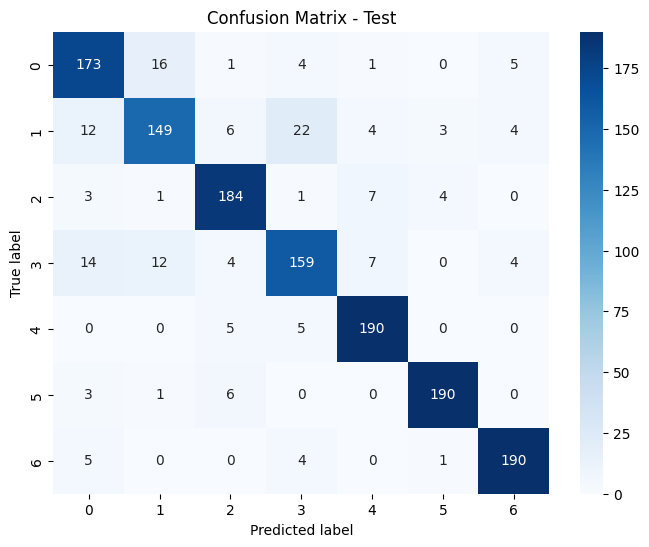

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Dự đoán trên tập test
test_pred = rf_model.predict(X_test_scaled)

# Accuracy
print("Test accuracy:", accuracy_score(y_test, test_pred))

# Classification report
print("Classification Report:")
print(classification_report(y_test, test_pred, digits=4))

# Số mẫu bị gán nhãn sai
wrong_indices = np.where(y_test != test_pred)[0]
print(f"Số lượng mẫu bị gán nhãn sai trên tập test: {len(wrong_indices)}")
print(f"Tỷ lệ mẫu sai: {len(wrong_indices) / len(y_test):.4%}")

if 'label_encoder' in locals():
    for i in wrong_indices[:10]:
        true_name = label_encoder.inverse_transform([y_test[i]])[0]
        pred_name = label_encoder.inverse_transform([test_pred[i]])[0]
        print(f"Index: {i} - True: {true_name} - Pred: {pred_name}")
else:
    for i in wrong_indices[:10]:
        print(f"Index: {i} - True: {y_test[i]} - Pred: {test_pred[i]}")

labels = label_encoder.classes_ if 'label_encoder' in locals() else np.unique(np.concatenate([y_test, test_pred]))
cm = confusion_matrix(y_test, test_pred, labels=range(len(labels)) if 'label_encoder' in locals() else labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Test')
plt.savefig("./images/cm_rf.png")
plt.show()


In [19]:
import os

save_dir = "/content/drive/MyDrive/processed_h5/"
os.makedirs(save_dir, exist_ok=True)

import joblib
joblib.dump(rf_model, save_dir + "rf_model.joblib")
joblib.dump(scaler, save_dir + "scaler.joblib")
if 'label_encoder' in locals():
    joblib.dump(label_encoder, save_dir + "label_encoder.joblib")


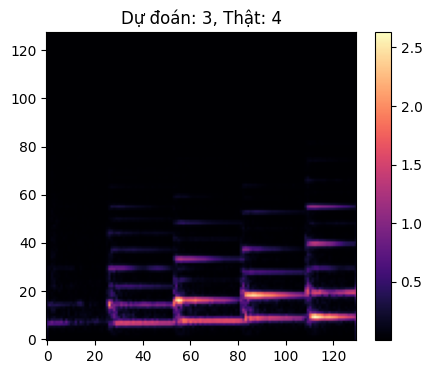

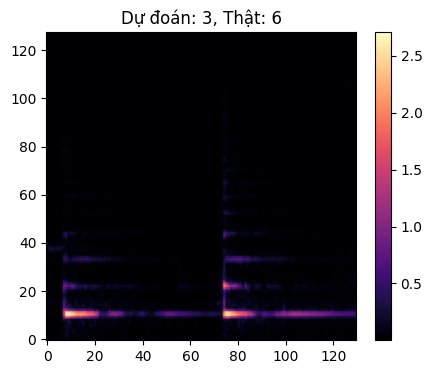

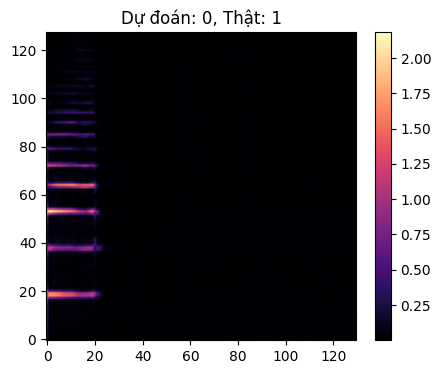

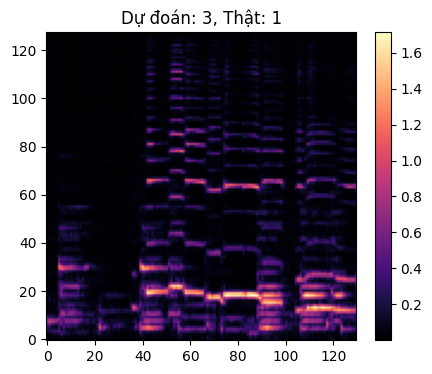

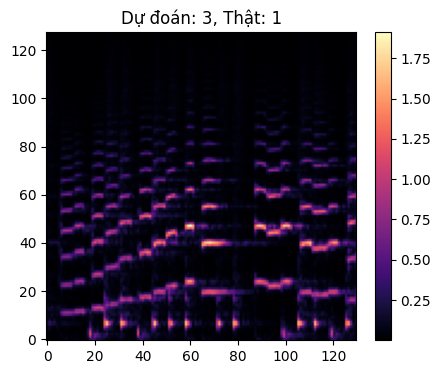

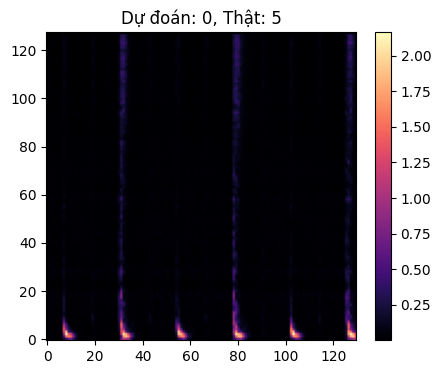

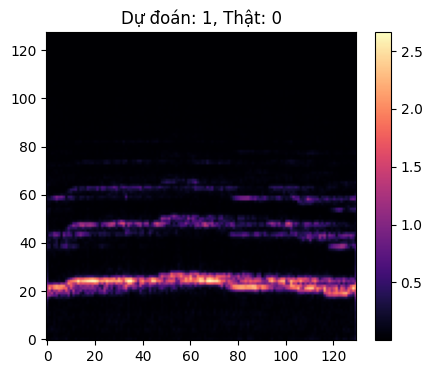

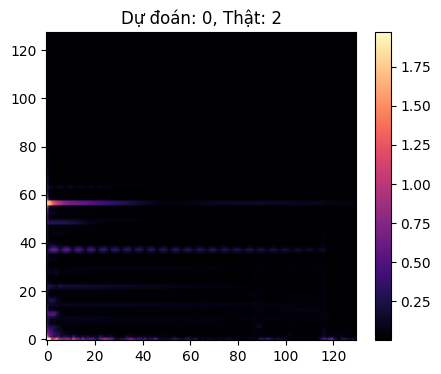

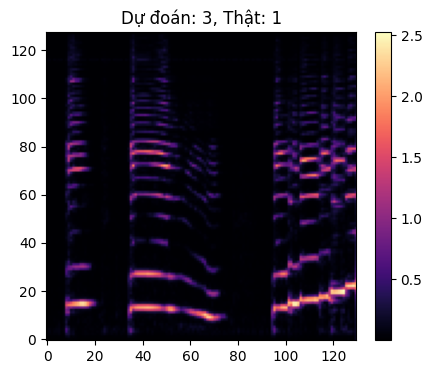

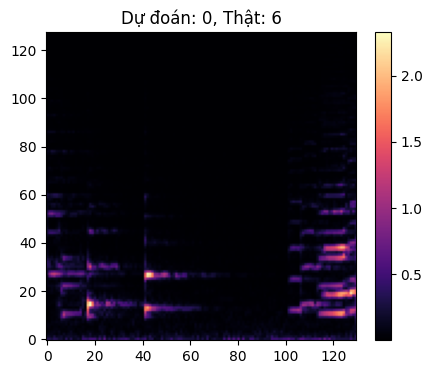

In [20]:
import matplotlib.pyplot as plt

for count, i in enumerate(wrong_indices[:10]):
    plt.figure(figsize=(5, 4))
    plt.imshow(X_test[i].reshape(128, 130), aspect='auto', origin='lower', cmap='magma')
    if 'label_encoder' in locals():
        true_label = label_encoder.inverse_transform([y_test[i]])[0]
        pred_label = label_encoder.inverse_transform([test_pred[i]])[0]
    else:
        true_label = y_test[i]
        pred_label = test_pred[i]
    plt.title(f"Dự đoán: {pred_label}, Thật: {true_label}")
    plt.colorbar()
    plt.show()
